<center>
    COMP4600/5500 - Reinforcement Learning

# Homework 8 - Policy Gradient

### Due: Monday, November 29th 11:59 pm
    
</center>

Student Name: Mohamed Martini

The purpose of this project is to study different properties of Policy Gradient algorithms with Function Approximation.

In [2]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mountain_car import MountainCar
import pygame as pg
from itertools import product, count
from collections import deque
from tqdm import tqdm
from IPython.display import clear_output

"""
Comment if you get an error, or install the following library to use latex with matplotlib on Linux:
sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
"""
plt.rcParams['text.usetex'] = True


pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


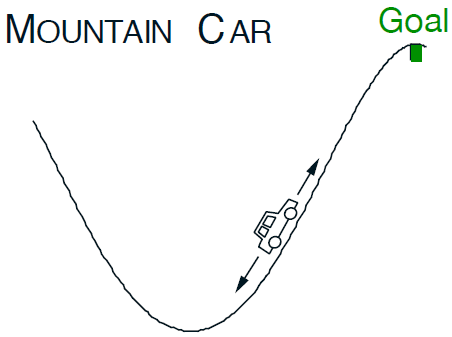


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.




**Note:** You have been given a simple implementation of the Mountain Car task. You can use your implementation of the function approximation from Homework 6, or implement a new one. 


In [3]:
def episode():
    car = MountainCar()
    x = np.random.uniform(-0.6, -0.4)
    v = 0
    X = [x]
    while True:
        a = np.random.choice(car.actions)
        x, v, r, goal_reached = car.move(x, v, a)
        X.append(x)
        if goal_reached:
            return X


In [4]:
FPS = 40
BG_COLOR = pg.Color(200, 200, 200)
CURVE_COLOR = pg.Color(70, 70, 70)
CAR_COLOR = pg.Color(200, 70, 70)

SCALE = 500
PAD = 200

X_MIN, X_MAX = -1.2, 0.5
Y_MAX, Y_MIN = 1, 0

WIDTH = int((X_MAX - X_MIN) * SCALE  + PAD)
HEIGHT = int((Y_MAX - Y_MIN) * SCALE  + PAD)


def transform(x, y):
    """transform an xy coordinate to pygame screen coordinates"""
    return (x + 1.2) * SCALE + PAD / 2, (1 - y) * SCALE + PAD / 2

def curve(x):
    return 0.45 * np.sin(3*x) + 0.55


class PgCar:

    def __init__(self):
        self.screen, self.bg = self.init()
        
    def init(self):
        pg.init()  # initialize pygame
        screen = pg.display.set_mode((WIDTH, HEIGHT))  # set up the screen
        pg.display.set_caption("Mohamed Martini")  # add a caption
        bg = pg.Surface(screen.get_size())  # get a background surface
        bg = bg.convert()
        bg.fill(BG_COLOR)
        screen.blit(bg, (0, 0))
        return screen, bg

    def draw_curve(self):
        start = None
        for x in np.arange(X_MIN, X_MAX, 0.001):
            end = transform(x, curve(x))
            try:
                pg.draw.line(self.screen, CURVE_COLOR, start, end, width=7)
            except:
                continue
            finally:
                start = end

    def render(self):
        """show the grid array on the screen"""
        pg.display.flip()
        pg.display.update()
    
    def reset_screen(self):
        self.screen.fill(BG_COLOR)
        self.draw_curve()
    
    def animate(self, X):
        """receive a list of positions on the x axis, and plot the movement of the screen"""
        clock = pg.time.Clock()
        radius = 20
        i = 0
        num_steps = len(X)
        run = True
        while run:
            clock.tick(FPS)
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    run = False
            if i == num_steps - 1:
                continue
            i += 1
            center = np.array((X[i], curve(X[i])))
            center = transform(*center)
            self.reset_screen()
            pg.draw.circle(self.screen, CAR_COLOR, center, radius, width=radius)
            self.render()
        pg.quit()

# X = episode()      
# PgCar().animate(X)


In [5]:
shift = np.array((1.2, 0.07))
scale = np.array((1.7, 0.14))

def xv_to_s(xv):
    """transform from xv to normalized state"""
    return (xv + shift) / scale

def s_to_xv(s):
    """transform from normalized state to xv"""
    return s * scale - shift


In [6]:
def _x_s(s: np.array):
    """return x(s) as fourier basis of state"""
    x = np.zeros(NUM_FEATURES)
    for i, c in enumerate(product(range(D + 1), repeat=K)):
        c = np.array(c)
        x[i] = np.cos(np.pi * s.T @ c)
    return x


def x_s(s: np.array):
    """
    return x(s) as fourier basis of state. 
    Look first if previously computated, else compute and store it
    """
    global BASIS
    try:
        return BASIS[tuple(s)]
    except KeyError:
        BASIS[tuple(s)] = _x_s(s)
        return BASIS[tuple(s)]

def x_sa(s: np.array, a: int):
    """return x(s, a) as fourier basis of state, shifted according to the action index"""
    x = np.zeros(NUM_FEATURES * NUM_ACTIONS)
    start = NUM_FEATURES * a
    end = start + NUM_FEATURES
    x[start: end] = x_s(s)
    return x
    
    
def h_s(s: np.array, theta: np.array):
    """return actions' preferences in state s"""
    h = np.zeros(NUM_ACTIONS)
    for a in range(NUM_ACTIONS):
        h[a] = theta @ x_sa(s, a)
    return h

def pi_s(s: np.array, theta: np.array):
    """return policy at state s"""
    h = h_s(s, theta)
    exp = np.exp(h - np.max(h))
    return exp / np.sum(exp)

def v_s(s: np.array, w: np.array):
    """return the value of a state given the weights vector of a specific action"""
    return w @ x_s(s)

def get_action(s, theta):
    """return index of action at state s according to weights theta"""
    policy = pi_s(s, theta)
    return np.random.choice(range(NUM_ACTIONS), p=policy), policy

def get_pi_gradient(s, a, policy):
    """compute gradient ln pi(a|s, theta), which equals x(s,a) = \sum_b \pi(b|s, theta) x(s,b)"""
    x = x_sa(s, a)
    summation = 0
    for i in range(NUM_ACTIONS):
        summation += policy[i] * x_sa(s, i)
    return x - summation


## Part I (COMP4600)

Implement REINFORCE with Baseline (p. 330).



In [7]:
def reinforce_w_baseline(num_episodes):

    gamma = 1
    alpha_w = 2e-11
    alpha_theta = 2e-11

    theta = np.zeros(NUM_ACTIONS * NUM_FEATURES)  # theta for each action
    W = np.zeros(NUM_FEATURES)  # weights for estimating v_s

    steps_per_e = np.zeros(num_episodes)

    for episode in range(num_episodes):
        # generate an episode following policy
        car = MountainCar()

        A_t = []
        S_t = []
        Pi_t = []

        xv = np.array((np.random.uniform(-0.6, -0.4), 0))
        s = xv_to_s(xv)

        for t in count():
            # select action
            a, policy = get_action(s, theta)
            S_t.append(s)
            A_t.append(a)
            Pi_t.append(policy)

            # take action, observe reward and next state
            x, v = s_to_xv(s)
            xp, vp, r, goal_reached = car.move(x, v, A[a])
            sp = xv_to_s(np.array((xp, vp)))
            
            # calculate the error (delta) - account for terminal state
            if goal_reached:
                steps_per_e[episode] = t
                break
            s = sp
        
        T = t
        for t in range(T):
            G = -1 * (T - t)
            delta = G - v_s(S_t[t], W)
            W += alpha_w * delta * x_s(S_t[t])
            theta += alpha_theta * delta * get_pi_gradient(S_t[t], A_t[t], Pi_t[t])
                
    return steps_per_e

In [8]:
BASIS = dict()  # to store the used fourier basis

In [ ]:
A = np.array([-1, 0, 1])
NUM_ACTIONS = 3
K = 2
D = 3
NUM_FEATURES = (D + 1) ** K

runs = 50
num_episodes = 50

steps_per_e_per_run_reinforce = np.zeros((runs, num_episodes))
for run in tqdm(range(runs)):
    steps_per_e = reinforce_w_baseline(num_episodes)
    steps_per_e_per_run_reinforce[run, :] = steps_per_e


episode = 11


## Part I (COMP5500)

Implement ACTOR-CRITIC with Eligibility Trace (p. 332).



In [1]:
def actor_critic_et(num_episodes):
    car = MountainCar()
    gamma = 1
    theta = np.zeros(NUM_ACTIONS * NUM_FEATURES)  # theta for each action
    W = np.zeros(NUM_FEATURES)  # weights for estimating v_s
    
    lambda_w = 0.8
    lambda_theta = 0.8
    
    alpha_w = 1e-3
    alpha_theta = 1e-3
    
    steps_per_e = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        # initialize s
        xv = np.array((np.random.uniform(-0.6, -0.4), 0))
        s = xv_to_s(xv)

        # reset z vectors
        z_theta = np.zeros_like(theta)
        z_w = np.zeros_like(W)

        # reset gamma multiplier
        I = 1
        
        # reset trajectory
        traj = [xv[0]]
        
        # loop through episode
        for t in count():
            # select action
            a, policy = get_action(s, theta)
            
            # take action, observe reward and next state
            x, v = s_to_xv(s)
            xp, vp, r, goal_reached = car.move(x, v, A[a])
            sp = xv_to_s(np.array((xp, vp)))
            traj.append(xp)
            
            # calculate the error (delta) - account for terminal state
            if goal_reached:
                v_sp = 0
            else:
                v_sp = v_s(sp, W)
            delta = r + gamma * v_sp  - v_s(s, W)
            
            # update z_w
            z_w = gamma * lambda_w * z_w + x_s(s)
            
            # update z_theta
            gradient = get_pi_gradient(s, a, policy)
            z_theta = gamma * lambda_theta * z_theta + I * gradient
            
            # update w
            W += alpha_w * delta * z_w
            
            # update theta
            theta += alpha_theta * delta * z_theta
            
            if goal_reached:
                car.goal_reached = False
                break
            
            I *= gamma
            s = sp
        
        steps_per_e[episode] = t
            
    return theta, traj, steps_per_e
            

## Part II

Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), the Function Approximation order, the discount factor ($\gamma$), and the $\lambda$-value. **Note:** you can consider the problem to be undiscounted.
 
1. Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs. 
2. Plot total reward on episode vs. number of episodes. This plot should be averaged over 50-100 runs.
3. Show an animation of the task for the final episode.


In [2]:
runs = 50
num_episodes = 50

steps_per_e_per_run_actor_critic = np.zeros((runs, num_episodes))
for run in tqdm(range(runs)):
    _, traj, steps_per_e = actor_critic_et(num_episodes)
    steps_per_e_per_run_actor_critic[run, :] = np.copy(steps_per_e)


NameError: name 'np' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle("Reinforce with Baseline vs.  ACTOR-CRITIC with Eligibility Trace - Mountain Car Problem\n \
$\gamma = 1$. $a_w = a_{\\theta} = 0.001$. $\lambda_w = \lambda_{\\theta} = 0.8$",
            fontsize=24)
xlabel = "Episode Number"
ylabels = ["Average Number of Timesteps (log scale)", "Average Reward"]

axes[0].plot(np.log10(steps_per_e_per_run_reinforce.mean(0)), label="Reinforce with Baseline")
axes[0].plot(np.log10(steps_per_e_per_run_actor_critic.mean(0)), label="ACTOR-CRITIC with Eligibility Trace")

axes[1].plot(-1 * steps_per_e_per_run_reinforce.mean(0), label="Reinforce with Baseline")  # reward = - number of steps
axes[1].plot(-1 * steps_per_e_per_run_actor_critic.mean(0), label="ACTOR-CRITIC with Eligibility Trace")  # reward = - number of steps

for i, ax in enumerate(axes):
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabels[i], fontsize=18)
    ax.set_title(f"{ylabels[i]} per Episode over {runs} Runs", fontsize=20)
    ax.grid()
    ax.legend()


plt.tight_layout()
plt.show()


In [ ]:
steps_per_e_per_run_reinforce

In [ ]:
car = PgCar()
car.animate(traj)


## Part III*

Implement the other algorithm and include plots for both algorithms in part II.

In [ ]:
# Your code here (you are allowed to import from an external python file (of your own impmenetation) 
# instead of copying all the code here)